In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import io
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

In [2]:
path = 'data/kaari2132023.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

df = pd.read_csv(path, dtype=dtypes)

df['datetime'] = pd.to_datetime(df['datetime'])

df

,datetime,gps_site,sat_id,gdlatr,gdlonr,los_tec,tec,azm,elm,gdlat,glon,gnss_type,slant_f,vtec,pair_id,curve_id,filtered,blrmvd
0,2023-03-21 00:00:00,b'0ams',1,64.532524,19.349890,7.319108,6.757187,-93.695259,66.141273,64.409019,16.322577,b'GLONASS ',1.068718,6.848495,GLONASS 0ams1,0,7.432506,-0.584011
1,2023-03-21 00:00:30,b'0ams',1,64.532524,19.349890,7.559455,7.005074,-93.473663,66.691986,64.417694,16.399038,b'GLONASS ',1.064910,7.098679,GLONASS 0ams1,0,7.460094,-0.361414
2,2023-03-21 00:01:30,b'0ams',1,64.532524,19.349890,7.706900,7.154760,-93.358940,66.967659,64.422279,16.442909,b'GLONASS ',1.063058,7.249745,GLONASS 0ams1,0,7.488637,-0.238892
3,2023-03-21 00:02:00,b'0ams',1,64.532524,19.349890,7.740303,7.198741,-93.241463,67.243530,64.426292,16.475420,b'GLONASS ',1.061240,7.293639,GLONASS 0ams1,0,7.516915,-0.223276
4,2023-03-21 00:02:30,b'0ams',1,64.532524,19.349890,7.669321,7.158023,-92.997871,67.795799,64.434814,16.551697,b'GLONASS ',1.057707,7.250894,GLONASS 0ams1,0,7.545177,-0.294283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8085267,2023-03-21 23:57:00,b'ylit',9,66.306602,23.667742,9.515786,7.572054,-132.467819,50.392902,64.604004,19.501953,b'GPS ',1.250118,7.611908,GPS ylit9,2,7.728938,-0.117029
8085268,2023-03-21 23:57:30,b'ylit',9,66.306602,23.667742,9.618620,7.675449,-132.512192,50.624043,64.611526,19.524801,b'GPS ',1.246285,7.717836,GPS ylit9,2,7.732732,-0.014896
8085269,2023-03-21 23:58:00,b'ylit',9,66.306602,23.667742,9.746588,7.821429,-132.609863,51.090988,64.638084,19.597088,b'GPS ',1.238659,7.868658,GPS ylit9,2,7.736907,0.131751
8085270,2023-03-21 23:59:00,b'ylit',9,66.306602,23.667742,9.640309,7.757446,-132.659317,51.321877,64.656937,19.645588,b'GPS ',1.234948,7.806247,GPS ylit9,2,7.741059,0.065188


## Delete the first and last 15 mins of each curve + elevation filter

In [3]:
MIN_ELEVATION = 20

def trim_curve(group):
    group = group.sort_values('datetime')
    start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
    end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
    return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

df = df.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)
df = df.loc[df['elm'] > MIN_ELEVATION]

C:\Users\virtanem\AppData\Local\Temp\ipykernel_11616\361853847.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


## Bin values into a grid

In [4]:
DATETIME = '2023-03-21 12:00:00'
RES = 0.5
METHOD = 'nearest'

specific_datetime = pd.to_datetime(DATETIME)
df_grid = df.copy()
df_grid = df_grid.loc[df_grid['datetime'] == specific_datetime]

x_grid = np.arange(min(df_grid['glon']), max(df_grid['glon'])+RES, RES)
y_grid = np.arange(min(df_grid['gdlat']), max(df_grid['gdlat'])+RES, RES)
X, Y = np.meshgrid(x_grid, y_grid)

Z = griddata((df_grid['glon'], df_grid['gdlat']), df_grid['blrmvd'], (X, Y), method=METHOD)

## Map all piercepoints

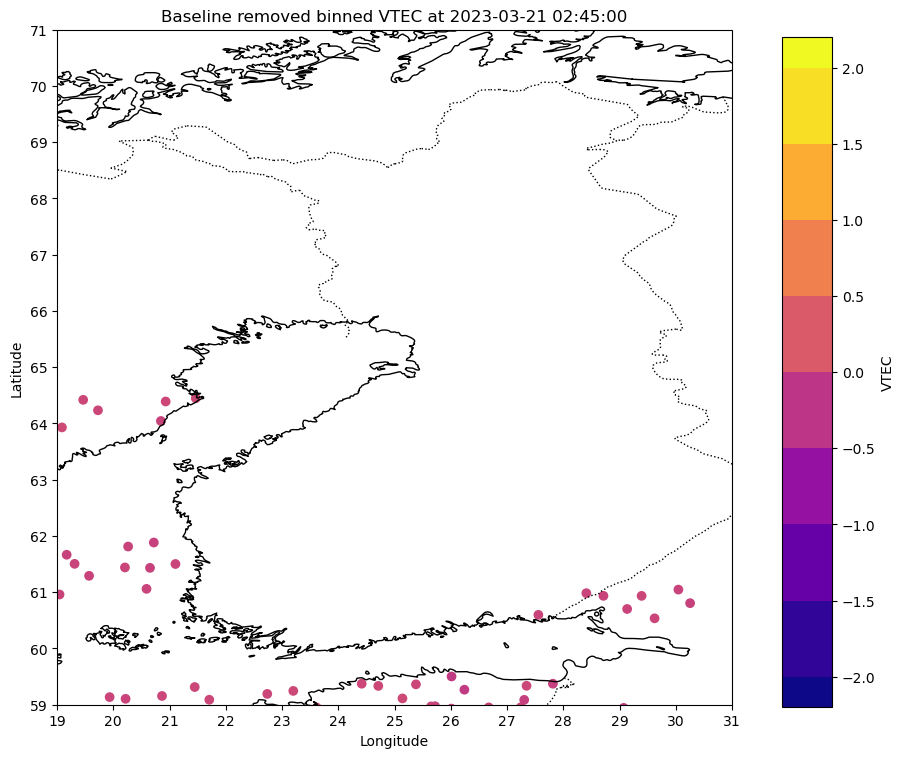

In [17]:
def create_fig_s(fig, ax, datetime, df, RES=0.5):
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned VTEC at {datetime}')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

def show_fig(datetime, df, RES=0.5):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_s(fig, ax, datetime, df, RES)
    plt.show(fig)

frames = sorted(df['datetime'].unique())
show_fig(frames[30*10], df, RES=RES)

## Heatmaps

### 2D histogram

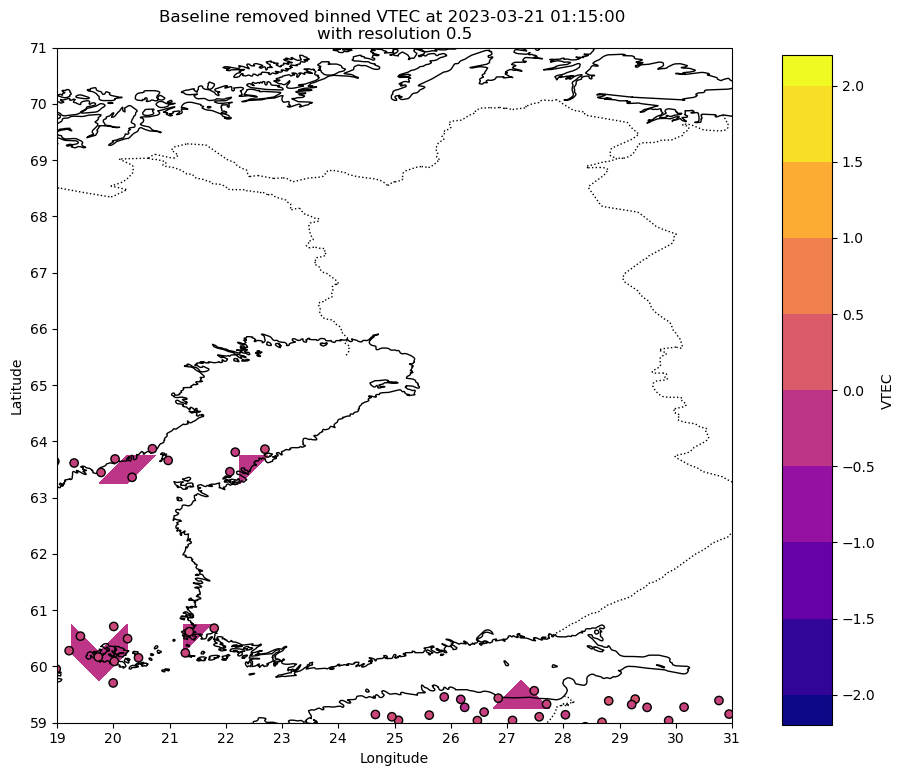

In [11]:
def create_fig_h(fig, ax, datetime, df, RES=0.5):
    df1 = df.loc[df['datetime'] == datetime]

    statistic, x_edges, y_edges, _ = histo2D(
        df1['glon'], df1['gdlat'], df1['blrmvd'], statistic='mean', 
        bins=[np.arange(19, 32 + RES, RES), np.arange(59, 72 + RES, RES)]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.contourf(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                          levels=np.linspace(-2, 2, 9), extend='both', transform=ccrs.PlateCarree())
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', edgecolors='k', 
                zorder=2, vmin=-2, vmax=2)  # Plot the original data points
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2,0.5), 
                        values = np.arange(-2,2.5,0.5), extend='both')
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned VTEC at {datetime} \nwith resolution {RES}')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

def show_fig(datetime, df, RES=0.5):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_h(fig, ax, datetime, df, RES)
    plt.show(fig)

frames = sorted(df['datetime'].unique())
show_fig(frames[120], df, RES=RES)

### pcolormesh

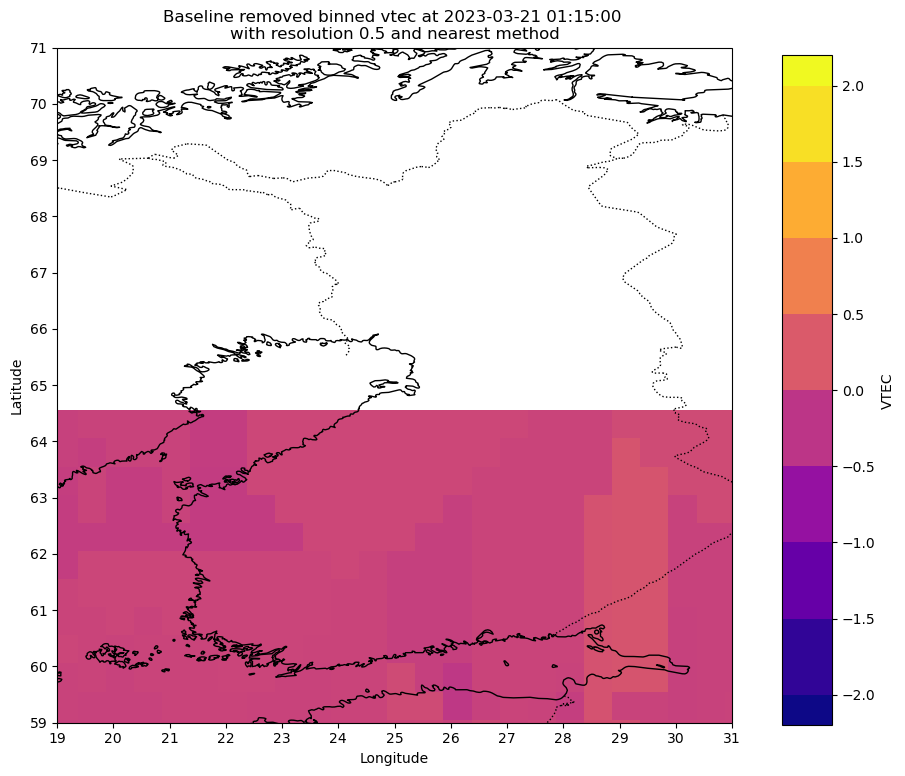

In [10]:
def create_fig_p(fig, ax, datetime, df, RES=0.5, METHOD='nearest'):
    df1 = df.loc[df['datetime'] == datetime]

    x_grid = np.arange(min(df1['glon']), max(df1['glon']) + RES, RES)
    y_grid = np.arange(min(df1['gdlat']), max(df1['gdlat']) + RES, RES)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y), method=METHOD)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = plt.pcolormesh(x_grid, y_grid, Z, cmap='plasma', shading='nearest', vmin=-2, vmax=2)

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2.5,0.5), extend='both'
    )
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned vtec at {datetime} \nwith resolution {RES} and {METHOD} method')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

def show_fig(datetime, df, RES=0.5, METHOD='nearest'):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_p(fig, ax, datetime, df, RES, METHOD)
    plt.show(fig)


frames = sorted(df['datetime'].unique())
show_fig(frames[120], df, RES=RES)

### contourf

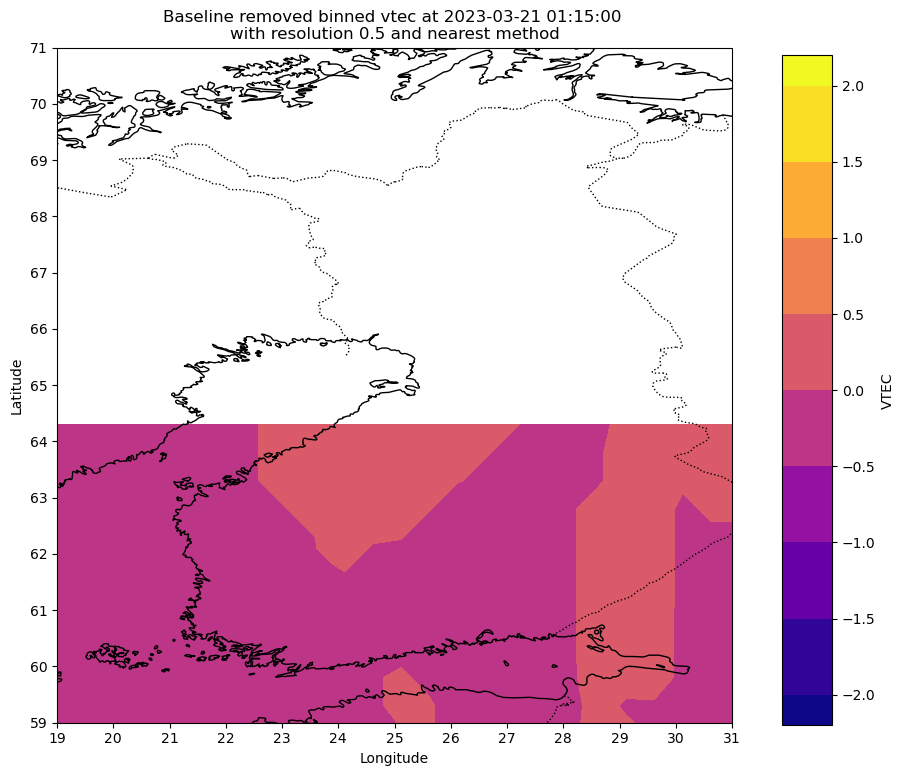

In [8]:
def create_fig_c(fig, ax, datetime, df, RES=0.5, METHOD='nearest'):
    df1 = df.loc[df['datetime'] == datetime]

    x_grid = np.arange(min(df1['glon']), max(df1['glon']) + RES, RES)
    y_grid = np.arange(min(df1['gdlat']), max(df1['gdlat']) + RES, RES)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y), method=METHOD)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))

    contour = ax.contourf(X, Y, Z, cmap='plasma', vmin=-2, vmax=2, levels=np.linspace(-2, 2, 9), extend='both')

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True,
                        ticks=np.arange(-2,2.5,0.5), boundaries = np.arange(-2,2,0.5), 
                        values = np.arange(-2,2.5,0.5), extend='both')
    cbar.set_label('VTEC')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned vtec at {datetime} \nwith resolution {RES} and {METHOD} method')

    ax.set_xlim(19, 31)
    ax.set_ylim(59, 71)

def show_fig(datetime, df, RES=0.5, METHOD='nearest'):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_c(fig, ax, datetime, df, RES, METHOD)
    plt.show(fig)

frames = sorted(df['datetime'].unique())
show_fig(frames[30*4], df, RES=RES)

## Strip plot

In [9]:
# LONG = 25

# df2 = df.loc[df['glon'] == LONG]

# pivot = df.pivot(index='gdlat', columns='datetime', values='blrmvd')
# sns.heatmap(pivot, cmap='viridis', vmin=-4, vmax=4)

# plt.gca().invert_yaxis()
# plt.xlabel('Datetime')
# plt.ylabel('Latitude')
# plt.title(f'TEC Heatmap for longitude {LONG}')

# plt.show()